### Solving Near-filed ptychography problem for the object and probe,
### $$\arg\min_{obj,prb}\Big\||D(prb\cdot S_r(obj))|-d\Big\|^2_2,$$
### with the Bilinear Hessian method

In [1]:
import cupy as xp # GPU version
# import numpy as xp # CPU version too slow!
import matplotlib.pyplot as plt
import time

In [2]:
n = 1024 ## detector size in each diemnsion, reduce if computations are on CPU

## Acquistion parameters

In [3]:
energy = 33.35 # [keV]
wavelength = 1.24e-09 / energy
npos = 16 # number of positions
z1 = 4.214*1e-3  # [m] position of the sample
detector_pixelsize = 6*1.01250442970688e-6 # 6x6 binning
focusToDetectorDistance = 1.28  # [m]

# adjustments for the cone beam
z2 = focusToDetectorDistance - z1
distance = (z1 * z2) / focusToDetectorDistance
magnification = focusToDetectorDistance / z1
voxelsize = xp.abs(detector_pixelsize / magnification)

print(f'{voxelsize=:.1e} nm')

voxelsize=2.0e-08 nm


## Read data

In [4]:
data = xp.load('data.npy').astype('float32')[:,512-n//2:512+n//2,512-n//2:512+n//2]
pos = xp.load('pos.npy').astype('float32')
nobj = n+n//8 # reconstructed object is larger to accomodate shifts

## show data and positions

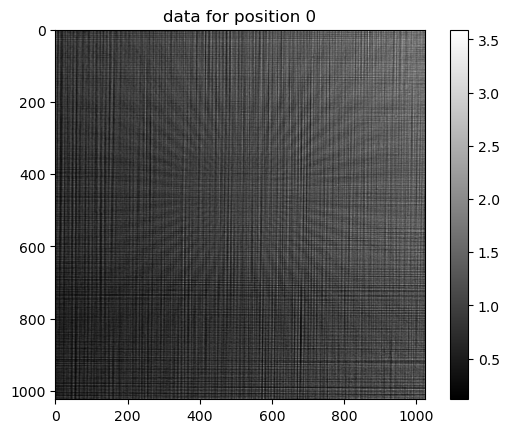

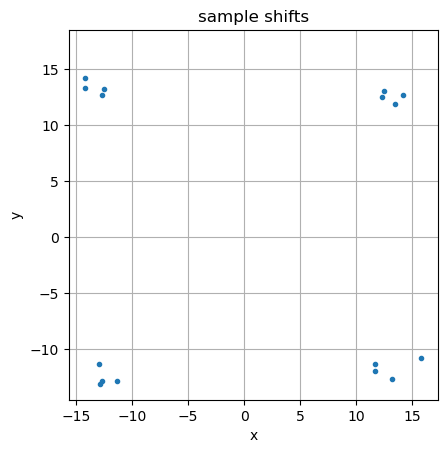

In [5]:
arr0 = data[0].get() if hasattr(data[0], "get") else xp.asarray(data[0])
plt.imshow(arr0,cmap='gray')
plt.title('data for position 0')
plt.colorbar()
plt.show()
arr0 = pos.get() if hasattr(pos, "get") else xp.asarray(pos)
plt.plot(arr0[:,1],arr0[:,0],'.')
plt.axis('square')
plt.title('sample shifts')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

# Fresnel kernel

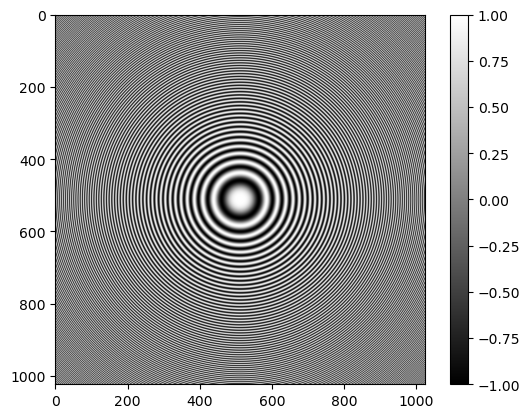

In [6]:
fx = xp.fft.fftfreq(n, d=voxelsize).astype("float32")
[fx, fy] = xp.meshgrid(fx, fx)
fker = xp.exp(-1j * xp.pi * wavelength * distance * (fx**2 + fy**2))
arr0 = xp.fft.fftshift(fker).real
arr0 = arr0.get() if hasattr(arr0, "get") else xp.asarray(arr0)
plt.imshow(arr0,cmap='gray')
plt.colorbar()

### Shift frequencies

In [7]:
x = xp.fft.fftfreq(nobj).astype("float32")
[y, x] = xp.meshgrid(x, x)
pos = pos[...,None,None]
exp_shift = xp.exp(-2 * xp.pi * 1j * (y * pos[:, 1] + x * pos[:, 0])).astype("complex64")


## Fresnel transform and shift operators

In [8]:
def D(obj):
    """Forward propagator"""
    return xp.fft.ifft2(xp.fft.fft2(obj) * fker)    

def DT(obj):
    """Adjoint propagator"""
    return xp.fft.ifft2(xp.fft.fft2(obj) / fker)    

def S(obj):
    """Shift operator"""
    sobj = xp.fft.ifft2(exp_shift * xp.fft.fft2(obj[None]))

    # crop to the detector size
    pad = nobj//2-n//2
    sobj = sobj[:,pad:-pad,pad:-pad]
    return sobj

def ST(obj):
    """Adjoint shift operator"""
    # pad with 0
    pad = nobj//2-n//2
    sobj = xp.pad(obj,((0,0),(pad,pad),(pad,pad)))
    
    # shift via swithicng to frequencies    
    sobj = xp.sum(xp.fft.ifft2(xp.fft.fft2(sobj)/exp_shift),axis=0)    
    return sobj

#### Real part of product and dot product


In [9]:
def reprod(a, b):
    return a.real * b.real + a.imag * b.imag

def redot(a, b):
    res = xp.vdot(a.view('float32'),b.view('float32'))
    return res


### Bilinear Hessian solver

In [10]:
rho_sq = [4,1]

def gradients(x,Fx,data):
    """Gradient via the Cascade rule"""  
    x11, _, x13 = x                
    
    td = data * Fx / xp.abs(Fx)
    y0 = 2  * (Fx - td) 

    tmp = DT(y0)  
    y11 = xp.sum(tmp* xp.conj(x13), axis=0)
    y12 = ST(tmp * xp.conj(x11))
        
    return [y11,y12]

def min(Fx,data):
    return xp.linalg.norm(xp.abs(Fx) - data) ** 2 

def calc_alpha(x,y,z,Fx,data):
    top = -sum(redot(yk, zk) / rho_sqk for yk, zk, rho_sqk in zip(y, z, rho_sq))
    
    x11, _, x13 = x
    z11, _, z13 = z
    
    df1z = D(z11 * x13 + x11 * z13)
    d2f1zz = 2 * D(z11 * z13)
    
    sFx = Fx/xp.abs(Fx)
    d0  = data / xp.abs(Fx)  
    tmp = Fx - data * sFx

    v1  = xp.sum((1.0 - d0) * reprod(df1z, df1z))
    v2  = xp.sum(d0 * (reprod(sFx, df1z) ** 2))

    bottom = 2.0 * (v1  + v2  + redot(tmp, d2f1zz))
    alpha = top / bottom
    return alpha

def calc_beta(x, y, z, Fx, data):
    x11, _, x13 = x
    y11, _, y13 = y
    z11, _, z13 = z

    df1y = D(y11 * x13 + x11 * y13)
    df1z = D(z11 * x13 + x11 * z13)
    d2f1yz = D(y11 * z13 + z11 * y13)
    d2f1zz = 2 * D(z11 * z13)
    
    sFx = Fx / xp.abs(Fx)     
    d0  = data / xp.abs(Fx)  
    tmp = Fx - data * sFx
    
    v1  = xp.sum((1.0 - d0) * reprod(df1z, df1z))
    v1  += xp.sum(d0 * (reprod(sFx, df1z) ** 2))

    v11 = xp.sum((1.0 - d0) * reprod(df1y, df1z))
    v11 += xp.sum(d0 * (reprod(sFx, df1y) * reprod(sFx, df1z)))

    top    = v11 + redot(tmp, d2f1yz)
    bottom = v1  + redot(tmp, d2f1zz)

    return top / bottom

import time

def BH(data, x, niter=1):
    start_time = time.time()
    
    data = xp.sqrt(data)
    rho_sq = [4, 1, 1]
            
    x.append(S(x[1]))

    for i in range(niter):    
        iter_start = time.time()
        
        Fx = D(x[0] * S(x[1]))    
        
        # gradients for each variable
        y = gradients(x, Fx, data)
        
        y.append(S(y[1]))
        y = [yk * rho_sqk for yk, rho_sqk in zip(y, rho_sq)]
        
        if i ==0:
            z = [-yk for yk in y]
            
        else:
            beta = calc_beta(x,y,z,Fx,data)
            z[:] = [-yk + beta * zk for yk, zk in zip(y, z)]            
        
        # step length
        alpha = calc_alpha(x,y,z,Fx,data)
                
        # update variables
        x[:] = [xk + alpha * zk for xk, zk in zip(x, z)]
        # ---- synchronize if using CuPy ----
        if hasattr(xp, "cuda"):
            xp.cuda.Stream.null.synchronize()

        iter_time = time.time() - iter_start
        total_time = time.time() - start_time

        if i % 10 == 0:
            print(
                f'{i} err: {min(Fx,data):.3e}  '
                f'total: {total_time:.2f}s  '
                f'iter: {iter_time:.3f}s'
            )   

    return x

### Run reconstruction 


0 err: 6.112e+05  total: 0.13s  iter: 0.103s
10 err: 9.479e+02  total: 0.47s  iter: 0.033s
20 err: 7.470e+02  total: 0.80s  iter: 0.033s
30 err: 5.689e+02  total: 1.13s  iter: 0.033s
40 err: 4.452e+02  total: 1.46s  iter: 0.033s
50 err: 3.620e+02  total: 1.80s  iter: 0.033s
60 err: 3.045e+02  total: 2.13s  iter: 0.033s
70 err: 2.641e+02  total: 2.46s  iter: 0.033s
80 err: 2.335e+02  total: 2.79s  iter: 0.033s
90 err: 2.098e+02  total: 3.12s  iter: 0.033s


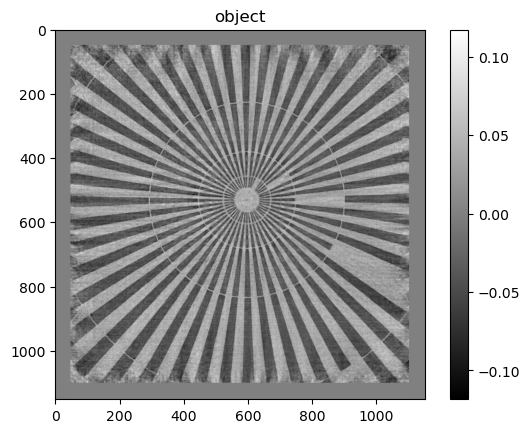

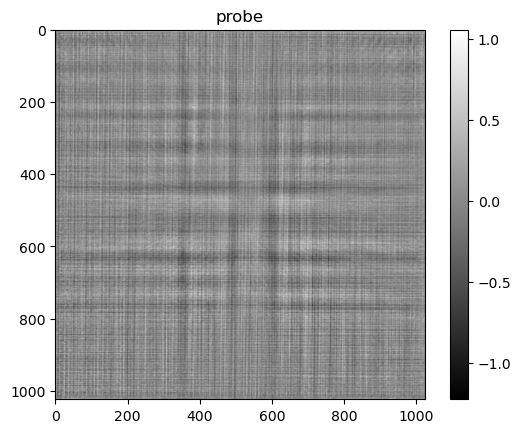

In [11]:
# initial guess
rec_obj = xp.ones([nobj,nobj],dtype='complex64')
rec_prb = xp.ones([n,n],dtype='complex64')

# run
rec_prb,rec_obj,_ = BH(data, [rec_prb, rec_obj], niter=100)

#show result
arr0 = xp.angle(rec_obj)
arr0 = arr0.get() if hasattr(arr0, "get") else xp.asarray(arr0)
plt.imshow(arr0,cmap='gray')
plt.colorbar()
plt.title('object')
plt.show()

arr0 = xp.angle(rec_prb)
arr0 = arr0.get() if hasattr(arr0, "get") else xp.asarray(arr0)
plt.imshow(arr0,cmap='gray')
plt.colorbar()
plt.title('probe')
plt.show()